In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

For now this notebook will be brief in description, but we'll clean it up for submission.

Import the merged dataset:

1 Row per MSA per Year. Columns are merged from the FBI Crime (normalized to population upstream) and ACS demographic databases.

In [52]:
df = pd.read_csv('data/derived/crime_ACS_merged.csv', low_memory=False)
df.columns  # [:20]

Index(['Aggravated assault', 'Burglary', 'Counties/principal cities',
       'Forcible rape', 'Larceny- theft', 'Larceny-theft', 'Larceny‑ theft',
       'Motor vehicle theft', 'Murder and nonnegligent manslaughter',
       'Population',
       ...
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1939 or earlier',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1940 to 1949',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1950 to 1959',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1960 to 1969',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1970 to 1979',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1980 to 1989',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1990 to 1999',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2000 to 2009',
       'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2010 to 2013',
 

In [53]:
df.head(3)

,Aggravated assault,Burglary,Counties/principal cities,Forcible rape,Larceny- theft,Larceny-theft,Larceny‑ theft,Motor vehicle theft,Murder and nonnegligent manslaughter,Population,...,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1939 or earlier,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1940 to 1949,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1950 to 1959,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1960 to 1969,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1970 to 1979,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1980 to 1989,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1990 to 1999,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2000 to 2009,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2010 to 2013,Percent; YEAR STRUCTURE BUILT - Total housing units - Built 2014 or later
0,227.8,649.9,"Rate per 100,000 inhabitants",NaN,2077.9,NaN,NaN,175.4,6.5,NaN,...,9.5,8.4,18.6,11.1,15.0,15.5,8.6,9.3,2.6,1.5
1,121.0,563.3,"Rate per 100,000 inhabitants",NaN,1857.3,NaN,NaN,144.0,6.0,NaN,...,19.0,7.2,14.9,11.6,13.9,9.1,12.9,9.4,1.5,0.6
2,534.9,949.8,"Rate per 100,000 inhabitants",NaN,2676.9,NaN,NaN,144.2,11.8,NaN,...,6.2,3.2,9.7,14.0,15.2,15.4,17.0,16.9,1.9,0.3


How many regions and years do we have? What's the histograms of value counts of region? View of "are the MSAs relatively stable or do they jump around over time?"

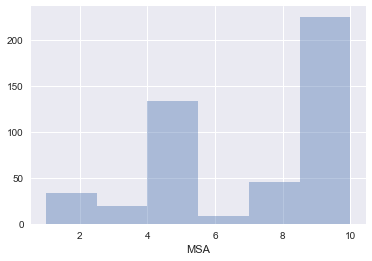

In [54]:
sns.distplot(df['MSA'].value_counts(), kde=False);

Many of the MSAs didn't survive the merge across all the years (not even 1 is in all 10 years). We'll have to see where this drops off.

Cut another way, are there some years that are particularly problematic?

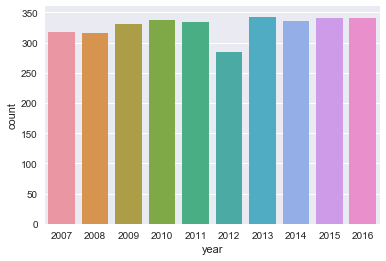

In [55]:
sns.countplot(x='year', data=df)

In general, do crimes tend to cluster together? I'd expect these relationships to be relatively high considering "safe" and "dangerous" neighborhoods.

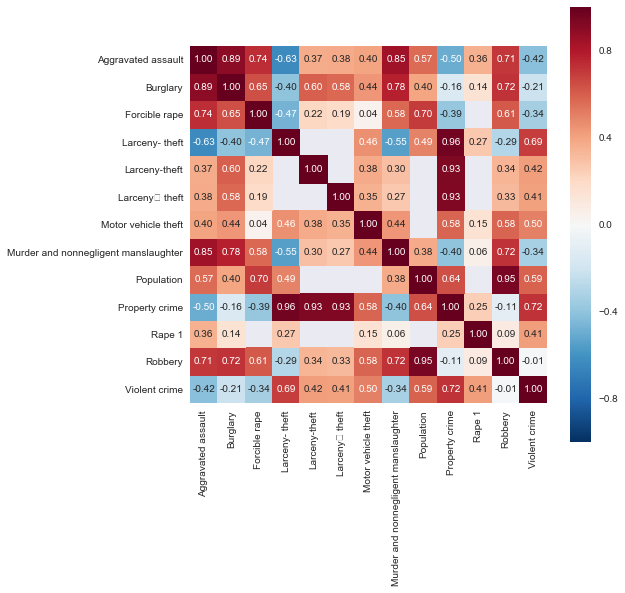

In [62]:
crime_columns = ['Aggravated assault', 'Burglary', 'Counties/principal cities',
                 'Forcible rape', 'Larceny- theft', 'Larceny-theft', 'Larceny‑ theft',
                 'Motor vehicle theft', 'Murder and nonnegligent manslaughter',
                 'Population', 'Property crime', 'Rape 1', 'Robbery', 'Violent crime']
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(df[crime_columns].corr(), annot=True, fmt='.02f', square=True, ax=ax);